# Peer-graded Assignment: Segmenting and Clustering Neighborhoods in Toronto
### Table of Contents
> [Setup](#setup)  
  [Create a pandas dataframe with Toronto postal codes, boroughs and neighbourhoods](#dataframe)  
  [Get the latitude and the longitude coordinates of each neighbourhood using the Geocoder package](#coordinates)  
  [Explore and cluster the neighbourhoods](#cluster)

<a class="anchor" id="setup"></a>
## Setup

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

import geocoder

import folium

import json
from pandas.io.json import json_normalize

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

<a class="anchor" id="dataframe"></a>
## Create a pandas dataframe with Toronto postal codes, boroughs and neighbourhoods
> Build the code to scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe

Fetch the web page with Toronto postal codes:

In [2]:
postCodeUrl = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
postCodeHtml = requests.get(postCodeUrl).text

Pass the HTML to BeautifulSoup() and extract the table with the postal codes:

In [3]:
postCodeSoup = BeautifulSoup(postCodeHtml, 'html5lib')
postCodeTable = postCodeSoup('table', {'class': "wikitable sortable"})[0]
print('HTML postal code table has {} columns and {} rows'.format(
    len(postCodeTable('th')),
    len(postCodeTable('tr'))))

HTML postal code table has 3 columns and 289 rows


Extract and print postal code table headers:

In [4]:
postCodeColumns = [str.strip(th.text) for th in postCodeTable('th')]
postCodeColumns

['Postcode', 'Borough', 'Neighbourhood']

Extract postal code table rows as a nested list and print first 5 rows:

In [5]:
postCodeRows = [[str.strip(td.text) for td in tr('td')] for tr in postCodeTable('tr')]
postCodeRows[:5]

[[],
 ['M1A', 'Not assigned', 'Not assigned'],
 ['M2A', 'Not assigned', 'Not assigned'],
 ['M3A', 'North York', 'Parkwoods'],
 ['M4A', 'North York', 'Victoria Village']]

Create postal code dataframe and print first 5 rows:

In [6]:
postCodeDf = pd.DataFrame(postCodeRows, columns=postCodeColumns)
postCodeDf.head()

,Postcode,Borough,Neighbourhood
0,None,None,None
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village


Explore dataframe for missing postcodes, not assigned boroughs, boroughs with not assigned neighbourhood, and postcode duplicates:

In [7]:
print('Missing postcodes:', postCodeDf['Postcode'].isna().sum())
print('Not assigned boroughs:', (postCodeDf['Borough'] == 'Not assigned').sum())
print('Boroughs with not assigned neighbourhood:', ((postCodeDf['Borough'] != 'Not assigned') &
                                                    (postCodeDf['Neighbourhood'] == 'Not assigned')).sum())
print('Postal code duplicates:', postCodeDf.duplicated('Postcode').sum())

Missing postcodes: 1
Not assigned boroughs: 77
Boroughs with not assigned neighbourhood: 1
Postal code duplicates: 108


Exclude missing postcodes and not assigned boroughs:

In [8]:
postCodeDf = postCodeDf[~(postCodeDf['Borough'].isna() | (postCodeDf['Borough'] == 'Not assigned'))]
postCodeDf.reset_index(drop=True, inplace=True)
print('Missing postcodes:', postCodeDf['Borough'].isna().sum())
print('Not assigned boroughs:', (postCodeDf['Borough'] == 'Not assigned').sum())

Missing postcodes: 0
Not assigned boroughs: 0


For boroughs with not assigned neighbourhood, assign the name of the borough to the neighbourhood:

In [9]:
boroughNeighMask = ((postCodeDf['Borough'] != 'Not assigned') & (postCodeDf['Neighbourhood'] == 'Not assigned'))
postCodeDf.loc[boroughNeighMask, 'Neighbourhood'] = postCodeDf.loc[boroughNeighMask, 'Borough']
print('Boroughs with not assigned neighbourhood:', ((postCodeDf['Borough'] != 'Not assigned') &
                                                    (postCodeDf['Neighbourhood'] == 'Not assigned')).sum())

Boroughs with not assigned neighbourhood: 0


Merge neighbourhoods with the same postcode:

In [10]:
postCodeDf.reset_index(drop=True, inplace=True)
for index, row in postCodeDf.iterrows():
    if index < postCodeDf.index[-1] and row['Postcode'] == postCodeDf.loc[index+1, 'Postcode']:
        postCodeDf.loc[index+1, 'Neighbourhood'] = row['Neighbourhood'] + ', ' + postCodeDf.loc[index+1, 'Neighbourhood']
        postCodeDf.drop(index, inplace=True)
postCodeDf.reset_index(drop=True, inplace=True)
print('Postal code duplicates:', postCodeDf.duplicated('Postcode').sum())

Postal code duplicates: 0


Print first 5 rows of the final postcode dataframe:

In [11]:
postCodeDf.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Queen's Park


Use the .shape method to print the number of rows of final the postal code dataframe:

In [12]:
print('Number of rows:', postCodeDf.shape[0])

Number of rows: 103


<a class="anchor" id="coordinates"></a>
## Get the latitude and the longitude coordinates of each neighbourhood using the Geocoder package

Add empty columns Latitude and Longitude to postal code dataframe:

In [22]:
postCodeDf = postCodeDf.reindex(columns=postCodeDf.columns.tolist() + ['Latitude', 'Longitude'])
postCodeDf.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,NaN,NaN
1,M4A,North York,Victoria Village,NaN,NaN
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",NaN,NaN
3,M6A,North York,"Lawrence Heights, Lawrence Manor",NaN,NaN
4,M7A,Queen's Park,Queen's Park,NaN,NaN


Get coordinates for each postal code from the World Geocoding Service (ArcGIS) using the Geocoder package (Google geocoding service doesn't seem to work):

In [15]:
geoLocatedNeighbourhoods = 0
for index, row in postCodeDf.iterrows():
    location = None
    while(location is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(row['Postcode']))
        location = g.json
    postCodeDf.loc[index, 'Latitude'] = location['lat']
    postCodeDf.loc[index, 'Longitude'] = location['lng']
    geoLocatedNeighbourhoods += 1
print('{} geolocated neighbourhoods'.format(geoLocatedNeighbourhoods))

103 geolocated neighbourhoods


Confirm that postal code coordinates have been added to the dataframe:

In [16]:
postCodeDf.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.752440,-79.329271
1,M4A,North York,Victoria Village,43.730421,-79.313320
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.655120,-79.362640
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.723125,-79.451589
4,M7A,Queen's Park,Queen's Park,43.661102,-79.391035


In [17]:
postCodeDf.tail()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
98,M8X,Etobicoke,"Montgomery Road, Old Mill North",43.653690,-79.511117
99,M4Y,Downtown Toronto,Church and Wellesley,43.666585,-79.381302
100,M7Y,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.648690,-79.385440
101,M8Y,Etobicoke,"Royal York South East, Sunnylea",43.632765,-79.489601
102,M8Z,Etobicoke,"Royal York South West, South of Bloor",43.624630,-79.526950


Confirm that no coordinates are missing:

In [21]:
postCodeDf.isna().sum()

Postcode         0
Borough          0
Neighbourhood    0
Latitude         0
Longitude        0
dtype: int64

Save the postal code dataframe to .CSV:

In [22]:
postCodeDf.to_csv('toronto-neighbourhoods.csv', index=False)

<a class="anchor" id="cluster"></a>
## Explore and cluster the neighbourhoods

### Explore the neighbourhoods utilizing the FourSquare location data

Load neighbourhoods and coordinates from the .CSV file created above, using the postal code as index:

In [2]:
postCodeDf = pd.read_csv('toronto-neighbourhoods.csv', index_col=0)
print('Number of rows:', postCodeDf.shape[0])
postCodeDf.head()

Number of rows: 103


,Borough,Neighbourhood,Latitude,Longitude
Postcode,,,,
M3A,North York,Parkwoods,43.752440,-79.329271
M4A,North York,Victoria Village,43.730421,-79.313320
M5A,Downtown Toronto,"Harbourfront, Regent Park",43.655120,-79.362640
M6A,North York,"Lawrence Heights, Lawrence Manor",43.723125,-79.451589
M7A,Queen's Park,Queen's Park,43.661102,-79.391035


Define FoursQuare API credentials and version:

In [3]:
with open('credentials.json') as f:
    credentials = json.load(f)
    CLIENT_ID = credentials['CLIENT_ID']
    CLIENT_SECRET = credentials['CLIENT_SECRET']
    VERSION = '20180605'

Create a function to get from FourSquare the top venues for a list of locations given their latitudes and longitudes:

In [4]:
def getNearbyVenues(postcodes, names, latitudes, longitudes, radius=500, limit=100):
    venuesList = []
    
    # Loop through locations
    for postcode, name, lat, lng in zip(postcodes, names, latitudes, longitudes):
        # Define the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit
        )
        
        # Send the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # Return location and relevant information for each nearby venue as a nested list
        venuesList.append([(
            postcode,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    
    # Create a dataframe from the locations and nearby venues nested list
    nearbyVenuesDf = pd.DataFrame([item for venueList in venuesList for item in venueList])
    nearbyVenuesDf.columns = ['Postcode',
                              'Neighbourhood', 
                              'Neighbourhood Latitude', 
                              'Neighbourhood Longitude', 
                              'Venue', 
                              'Venue Latitude', 
                              'Venue Longitude', 
                              'Venue Category']
    
    # Return the locations and nearby venues dataframe
    return(nearbyVenuesDf)

Get nearby venues from FourSquare, save as .csv and show first 5 venues:

In [5]:
exploreRadius = 1000
exploreLimit = 100

In [6]:
nearbyVenuesDf = getNearbyVenues(postcodes = postCodeDf.index,
                                 names=postCodeDf['Neighbourhood'],
                                 latitudes=postCodeDf['Latitude'],
                                 longitudes=postCodeDf['Longitude'],
                                 radius=exploreRadius,
                                 limit=exploreLimit)

nearbyVenuesDf.head()

,Postcode,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M3A,Parkwoods,43.75244,-79.329271,Brookbanks Park,43.751976,-79.332140,Park
1,M3A,Parkwoods,43.75244,-79.329271,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
2,M3A,Parkwoods,43.75244,-79.329271,Tim Hortons,43.760668,-79.326368,Café
3,M3A,Parkwoods,43.75244,-79.329271,A&W Canada,43.760643,-79.326865,Fast Food Restaurant
4,M3A,Parkwoods,43.75244,-79.329271,Bruno's valu-mart,43.746143,-79.324630,Grocery Store


Save results as .CSV:

In [7]:
filename = 'nearby-venues-r' + str(exploreRadius) + '-l' + str(exploreLimit) + '.csv'

In [8]:
nearbyVenuesDf.to_csv(filename, index=False)
print('Nearby venues with explore radius={} and limit={} saved as \'{}\''.format(exploreRadius, exploreLimit, filename))

Nearby venues with explore radius=1000 and limit=100 saved as 'nearby-venues-r1000-l100.csv'


Reload venues from .CSV file and check number of venues per neighbourhood:

In [9]:
nearbyVenuesDf = pd.read_csv(filename)
nearbyVenuesDf['Neighbourhood'].value_counts()

Business Reply Mail Processing Centre 969 Eastern    100
Willowdale South                                     100
Railway Lands, South Niagara                         100
First Canadian Place, Underground city               100
Little Portugal, Trinity                             100
                                                    ... 
Humber Summit                                          7
Rouge, Malvern                                         6
Downsview Central                                      4
Rouge Hill, Port Union                                 4
Silver Hills, York Mills                               4
Name: Neighbourhood, Length: 102, dtype: int64

Add a 'Venue Density' column to postCodeDf to reflect the differences in venue density between neighbourhoods:

In [10]:
venueDensityPs = nearbyVenuesDf['Postcode'].value_counts() / exploreLimit
venueDensityPs.name = 'Venue Density'
postCodeDf = postCodeDf.join(venueDensityPs)
postCodeDf.head()

,Borough,Neighbourhood,Latitude,Longitude,Venue Density
Postcode,,,,,
M3A,North York,Parkwoods,43.752440,-79.329271,0.28
M4A,North York,Victoria Village,43.730421,-79.313320,0.10
M5A,Downtown Toronto,"Harbourfront, Regent Park",43.655120,-79.362640,1.00
M6A,North York,"Lawrence Heights, Lawrence Manor",43.723125,-79.451589,0.99
M7A,Queen's Park,Queen's Park,43.661102,-79.391035,1.00


Plot neighbourhoods with a marker area proportional to venue density:

In [11]:
# Compute coordinates for folium map center
meanLat = postCodeDf['Latitude'].mean()
meanLng = postCodeDf['Longitude'].mean()

# Create folium map
neighbourhoodMap = folium.Map(
    location=[meanLat, meanLng],
    zoom_start = 11,
)

# Add neighbourhoods as markers
for _, label, lat, lng, density in postCodeDf.values:
    folium.CircleMarker(
        [lat, lng],
        radius=10*np.sqrt(density),
        popup=folium.Popup(label, parse_html=True),
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(neighbourhoodMap)

# Show neighbourhoods
neighbourhoodMap

Plot only neighbourhoods in boroughs that contain the word 'Toronto':

In [12]:
# Create a mask for boroughs that contain the word 'Toronto'
torontoMask = [('Toronto' in borough) for borough in postCodeDf['Borough']]
print('Number of rows:', postCodeDf[torontoMask].shape[0])

Number of rows: 38


In [13]:
# Compute coordinates for folium map center
meanLat = postCodeDf[torontoMask]['Latitude'].mean()
meanLng = postCodeDf[torontoMask]['Longitude'].mean()

# Create folium map
torontoNeighbourhoodMap = folium.Map(
    location=[meanLat, meanLng],
    zoom_start = 11,
)

for _, label, lat, lng, density in postCodeDf[torontoMask].values:
    folium.CircleMarker(
        [lat, lng],
        radius=10*np.sqrt(density),
        popup=folium.Popup(label, parse_html=True),
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(torontoNeighbourhoodMap)

torontoNeighbourhoodMap

As Venue density appears to be much more homogeneous for neighbourhoods in boroughs that contain the word 'Toronto'  than for all neighbourhoods, only neighbournoods in boroughs that contain the word 'Toronto' will be clustered, 

Apply the 'Toronto' in borough filter to neighbourhood and nearby venue dataframes:

In [14]:
torontoPostCodeDf = postCodeDf[torontoMask]
torontoNearbyVenuesDf = nearbyVenuesDf[nearbyVenuesDf['Postcode'].isin(torontoPostCodeDf.index)]

Compute venue frequency per neighbourhood and print the top 5 venue categories per neighbourhood:

In [15]:
nTopCat = 5

venueFrequencyPs = torontoNearbyVenuesDf.groupby('Neighbourhood')['Venue Category'].value_counts(normalize=True)
venueFrequencyPs.name = 'Frequency'
print(venueFrequencyPs.groupby(level='Neighbourhood').nlargest(nTopCat).reset_index(level=0, drop=True).round(2).to_string())

Neighbourhood                                      Venue Category               
Berczy Park                                        Coffee Shop                      0.10
                                                   Hotel                            0.06
                                                   Café                             0.05
                                                   Beer Bar                         0.04
                                                   Japanese Restaurant              0.04
Business Reply Mail Processing Centre 969 Eastern  Coffee Shop                      0.06
                                                   Hotel                            0.06
                                                   Café                             0.04
                                                   American Restaurant              0.03
                                                   Bar                              0.03
Cabbagetown, St. James Town  

### Cluster the neighbourhoods
> Use the relative frequency of each venue category for each neighbourhood as the feature set, and KMeans as the clustering algorithm

Create the feature dataframe with the relative frequency of each venue category for each neighbourhood:

In [16]:
featuresDf = venueFrequencyPs.unstack(level='Venue Category').fillna(0)
featuresDf.head()

Venue Category,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint,Yoga Studio
Neighbourhood,,,,,,,,,,,,,,,,,,,,,
Berczy Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010,...,0.0,0.00,0.01,0.0,0.00,0.00,0.0,0.00,0.0,0.00
Business Reply Mail Processing Centre 969 Eastern,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030,...,0.0,0.00,0.01,0.0,0.00,0.00,0.0,0.00,0.0,0.01
"Cabbagetown, St. James Town",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025,...,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00
Central Bay Street,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020,...,0.0,0.01,0.03,0.0,0.00,0.00,0.0,0.00,0.0,0.01
Christie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010,...,0.0,0.00,0.01,0.0,0.02,0.01,0.0,0.01,0.0,0.00


Check that total sum of venue category frequencies equals 1 for all neighbourhoods:

In [17]:
featuresDf.sum(axis=1)

Neighbourhood
Berczy Park                                          1.0
Business Reply Mail Processing Centre 969 Eastern    1.0
Cabbagetown, St. James Town                          1.0
Central Bay Street                                   1.0
Christie                                             1.0
Church and Wellesley                                 1.0
Commerce Court, Victoria Hotel                       1.0
Davisville                                           1.0
Davisville North                                     1.0
Design Exchange, Toronto Dominion Centre             1.0
Dovercourt Village, Dufferin                         1.0
Exhibition Place, Parkdale Village                   1.0
First Canadian Place, Underground city               1.0
Forest Hill North, Forest Hill West                  1.0
Grange Park, Kensington Market                       1.0
Harbord, University of Toronto                       1.0
Harbourfront, Regent Park                            1.0
High Park, The Ju

To cluster the neighbourhoods, run KMeans for different values of n_clusters and plot the corresponding model scores vs n_clusters to pick the best model using the "elbow" visual method:

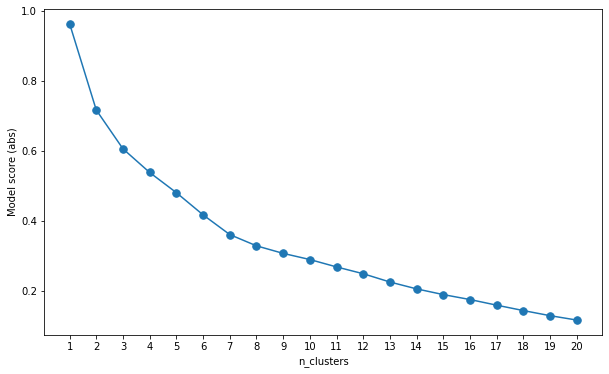

In [18]:
kVal = range(1,21)
kScores = []

for k in kVal:
    kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=-1)
    kmeans.fit(featuresDf)
    kScores.append(abs(kmeans.score(featuresDf)))

plt.figure(figsize=(10, 6))
plt.plot(kVal, kScores, marker='.', markersize=15)
plt.xticks(kVal)
plt.xlabel('n_clusters')
plt.ylabel('Model score (abs)')
plt.show()

The plot suggests that the best value for n_clusters could be 7.  

Run KMeans to cluster the neighbourhoods into 7 clusters, add a 'Cluster' column to the neighbourhoods dataframe, and print the resulting number of neighbourhoods per cluster:

In [19]:
# Run KMeans with n_clusters = 7
kBest = 7
kmeansBest = KMeans(n_clusters=kBest, random_state=0, n_jobs=-1)
kmeansBest.fit(featuresDf)

# Remove 'Cluster' column if created in a previous run
if 'Cluster' in torontoPostCodeDf.columns:
    torontoPostCodeDf.drop(columns=['Cluster'], inplace=True)

# Add 'Cluster' column to neighbourhoods dataframe torontoPostCodeDf
clusterPs = pd.Series(kmeansBest.labels_, index=featuresDf.index, name='Cluster')
torontoPostCodeDf = pd.merge(torontoPostCodeDf, clusterPs, left_on='Neighbourhood', right_index=True)

# Print number of neighbourhoods per cluster
torontoPostCodeDf['Cluster'].value_counts(sort=False)

0     8
1     1
2    18
3     1
4     1
5     8
6     1
Name: Cluster, dtype: int64

Plot the clusters:

In [20]:
# Set color scheme for the clusters
colorsArray = cm.Accent(np.linspace(0, 1, kBest))
colorsList = [colors.rgb2hex(i) for i in colorsArray]


clusterMap = folium.Map(
    location=[meanLat, meanLng],
    zoom_start = 12,
)

for _, neighbourhood, lat, lng, density, cluster in torontoPostCodeDf.values:
    label = neighbourhood + ' [Cluster {}]'.format(cluster)
    folium.CircleMarker(
        [lat, lng],
        radius=10*np.sqrt(density),
        popup=folium.Popup(label, parse_html=True),
        fill=True,
        color=colorsList[cluster],
        fill_color=colorsList[cluster],
        fill_opacity=0.6
    ).add_to(clusterMap)

clusterMap

Print cluster and 10 top venues for each neighbourhood:

In [21]:
nTopVenues = 10

# Add cluster to venue frequency
clusteredVenueFrequencyDf = pd.merge(clusterPs.reset_index(), venueFrequencyPs.reset_index())

# Compute frequency rank for each neighbourhood
venueRank = clusteredVenueFrequencyDf.groupby(['Neighbourhood'])['Frequency'].rank(ascending=False, method='first')
venueRank.name = 'Rank'

# Add rank to cluster and venue frequency
clusteredVenueFrequencyDf = pd.concat([clusteredVenueFrequencyDf, venueRank], axis=1)

# Print top venues for each cluster / neighbourhood
clusteredVenueFrequencyDf.set_index(['Cluster', 'Neighbourhood', 'Rank']).unstack('Rank')['Venue Category'].iloc[:, :nTopVenues]

Rank                                                                    1.0   \
Cluster Neighbourhood                                                          
0       Dovercourt Village, Dufferin                                     Bar   
        Exhibition Place, Parkdale Village                              Café   
        Forest Hill North, Forest Hill West                             Café   
        Grange Park, Kensington Market                                  Café   
        Harbord, University of Toronto                                  Café   
        High Park, The Junction South                                   Café   
        Little Portugal, Trinity                                         Bar   
        Studio District                                          Coffee Shop   
1       Roselawn                                                    Pharmacy   
2       Cabbagetown, St. James Town                                     Park   
        Central Bay Street                                       Coffee Shop   
        Christie                                           Korean Restaurant   
        Church and Wellesley                                     Coffee Shop   
        Davisville                                         Indian Restaurant   
        Davisville North                                         Coffee Shop   
        Harbourfront, Regent Park                                Coffee Shop   
        Moore Park, Summerhill East                              Coffee Shop   
        North Midtown, Yorkville                                 Coffee Shop   
        North Toronto West                                       Coffee Shop   
        Parkdale, Roncesvalles                                   Coffee Shop   
        Railway Lands, South Niagara                             Coffee Shop   
        Runnymede, Swansea                                       Coffee Shop   
        Ryerson, Garden District                                 Coffee Shop   
        South Hill, Summerhill West                              Coffee Shop   
        The Beaches                                                      Pub   
        The Beaches West, India Bazaar                     Indian Restaurant   
        The Danforth West, Riverdale                        Greek Restaurant   
3       Lawrence Park                                              Bookstore   
4       Rosedale                                                        Park   
5       Berczy Park                                              Coffee Shop   
        Business Reply Mail Processing Centre 969 Eastern        Coffee Shop   
        Commerce Court, Victoria Hotel                           Coffee Shop   
        Design Exchange, Toronto Dominion Centre                 Coffee Shop   
        First Canadian Place, Underground city                   Coffee Shop   
        King, Richmond                                           Coffee Shop   
        St. James Town                                           Coffee Shop   
        Stn A PO Boxes 25 The Esplanade                          Coffee Shop   
6       Toronto Islands, Union Station                       Harbor / Marina   

Rank                                                                                2.0   \
Cluster Neighbourhood                                                                      
0       Dovercourt Village, Dufferin                                              Bakery   
        Exhibition Place, Parkdale Village                                   Coffee Shop   
        Forest Hill North, Forest Hill West                           Italian Restaurant   
        Grange Park, Kensington Market                     Vegetarian / Vegan Restaurant   
        Harbord, University of Toronto                                            Bakery   
        High Park, The Junction South                                                Bar   
        Little Portugal, Trinity                               